In [50]:
import cv2
import base64
import numpy as np
import matplotlib.pyplot as plt

from io import BytesIO
from openai import OpenAI
from PIL import Image
from tqdm import tqdm

In [51]:
import re
import easyocr

reader = easyocr.Reader(['en'])
def process_string(s):
    s = s.replace(" ", "")  # Remove all whitespaces
    if re.fullmatch(r"\d+/\d+/\d+", s):  # Check if it matches int/int/int
        return s
    return None 

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [84]:
video_path = "/Users/rusiq/Downloads/youtube_dl/katka3_nosound1080p.mp4"
frame_number = 5500
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()
cap.release()

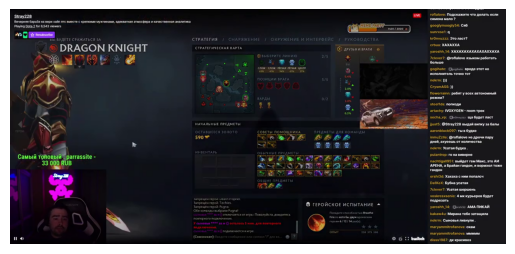

In [85]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

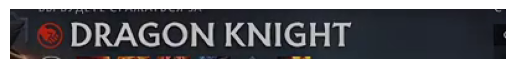

In [86]:
x, y, w, h = 80, 80, 400, 40  # Change these values based on your ROI
cropped = frame[y:y+h, x:x+w]

# Cell 5: Show cropped frame
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

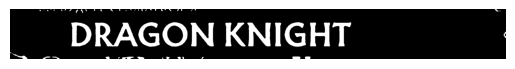

In [87]:
gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
gray = cv2.resize(gray, None, fx=7, fy=7, interpolation=cv2.INTER_CUBIC)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

# Apply adaptive thresholding with Otsu's binarization
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Show result
plt.imshow(binary, cmap='gray')
plt.axis('off')
plt.show()

In [92]:
result = reader.readtext(binary, detail = 0)
print(result)

['DRAGON', 'KNIGHT']


In [93]:
def upload_and_get_content_id(AUTH_JSON, video_file_path, title, description, privacy_status="private"):
    """
    Upload a video to YouTube and get Content ID information during the checks phase
    
    Args:
        video_file_path: Path to the local video file
        title: Title for the YouTube video
        description: Description for the YouTube video
        privacy_status: Privacy setting ("private", "public", or "unlisted")
        
    Returns:
        Content ID information including track names and timings
    """
    from googleapiclient.discovery import build
    from googleapiclient.http import MediaFileUpload
    from google.oauth2.credentials import Credentials
    import time
    
    # Authenticate with OAuth 2.0 (you need to have credentials set up)
    creds = Credentials.from_authorized_user_info(info=AUTH_JSON)
    youtube = build('youtube', 'v3', credentials=creds)
    
    # Define video metadata
    body = {
        'snippet': {
            'title': title,
            'description': description,
            'categoryId': '22'  # People & Blogs category
        },
        'status': {
            'privacyStatus': privacy_status,
            'selfDeclaredMadeForKids': False
        }
    }
    
    # Create upload request
    media = MediaFileUpload(video_file_path, resumable=True)
    upload_request = youtube.videos().insert(part='snippet,status', body=body, media_body=media)
    
    # Execute upload
    response = upload_request.execute()
    video_id = response['id']
    
    # Poll for Content ID information during the checks phase
    content_id_info = None
    for _ in range(30):  # Try for up to 5 minutes (30 x 10 seconds)
        time.sleep(10)
        
        # Get processing status including Content ID checks
        status_response = youtube.videos().get(
            part='processingDetails,contentDetails',
            id=video_id
        ).execute()
        
        processing_status = status_response.get('processingDetails', {})
        
        # Check if Content ID processing is complete
        if processing_status.get('processingStatus') == 'succeeded' and 'contentDetails' in status_response:
            # Get Content ID claims information
            claims_response = youtube.videos().get(
                part='contentDetails',
                id=video_id
            ).execute()
            
            if 'contentDetails' in claims_response and 'contentClaims' in claims_response['contentDetails']:
                content_id_info = claims_response['contentDetails']['contentClaims']
                break
    
    return content_id_info

In [104]:
import json
with open("/Users/rusiq/Downloads/youtube_dl/youtube_creds.json", "r") as creds:
    youtube_creds = json.load(creds)


In [106]:
upload_and_get_content_id(youtube_creds["web"], "/Users/rusiq/Downloads/youtube_dl/katka2.mp4", 
                          "test", "test", privacy_status="private")

ValueError: Authorized user info was not in the expected format, missing fields refresh_token.